## Image copression with MDCT

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.fftpack import dct, idct
from scipy.signal import get_window

In [ ]:
# Define the quantization matrix
quantization_matrix = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ],
    dtype=np.float32,
)


In [ ]:
def calculate_psnr(img1: np.ndarray[np.uint8], img2: np.ndarray[np.uint8]) -> float:
    mse = np.mean((img1 - img2) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    return psnr

In [ ]:
def number_of_elements(blocks: list[np.ndarray[np.int32]]) -> int:
    total_elements = 0
    for block in blocks:
        total_elements += np.trim_zeros(block, "b").size
    return total_elements

In [ ]:
def total_number_of_elements(
    blocks: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    color: bool,
) -> int:
    total_elements = 0
    if color:
        total_elements = (
            number_of_elements(blocks[0])
            + number_of_elements(blocks[1])
            + number_of_elements(blocks[2])
        )
    else:
        total_elements = number_of_elements(blocks)
    return total_elements

In [ ]:
def zigzag_scan(block: np.ndarray[np.int32]) -> np.ndarray[np.int32]:
    block_size = block.shape[0]
    zigzag_arr = np.concatenate(
        [
            np.diagonal(block[::-1, :], i)[:: (2 * (i % 2) - 1)]
            for i in range(1 - block_size, block_size)
        ]
    )
    return zigzag_arr

In [ ]:
def zigzag_unscan(
    zigzag_arr: np.ndarray[np.int32], block_size: int
) -> np.ndarray[np.float32]:
    block = np.zeros((block_size, block_size), dtype=np.float32)
    x, y = 0, 0
    for num in zigzag_arr:
        block[x, y] = num
        if (x + y) % 2 == 0:
            if y == block_size - 1:
                x += 1
            elif x == 0:
                y += 1
            else:
                x -= 1
                y += 1
        else:
            if x == block_size - 1:
                y += 1
            elif y == 0:
                x += 1
            else:
                x += 1
                y -= 1
    return block

In [ ]:
def mdct(x):
    N = len(x)
    window = get_window('hamming', N)
    x_windowed = x * window
    return dct(x_windowed, type=2, norm='ortho')

In [ ]:
def imdct(X):
    N = len(X)
    x_windowed = idct(X, type=2, norm='ortho')
    window = get_window('hamming', N)
    return x_windowed / window

In [ ]:
def grayscale_jpeg_encoder(
    img: np.ndarray[np.uint8], block_size: int, num_coefficients: int
) -> list[np.ndarray[np.int32]]:
    height, width = img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size
    padded_img = np.zeros((padded_height, padded_width), dtype=np.uint8)
    padded_img[:height, :width] = img

    padded_img = padded_img.astype(np.float32) - 128

    blocks = [
        padded_img[i : i + block_size, j : j + block_size]
        for i in range(0, padded_height, block_size)
        for j in range(0, padded_width, block_size)
    ]

    mdct_blocks = [mdct(block.flatten()).reshape(block_size, block_size) for block in blocks]

    resized_quantization_matrix = cv.resize(
        quantization_matrix, (block_size, block_size), cv.INTER_CUBIC
    )

    quantized_blocks = [
    np.round(block / resized_quantization_matrix).astype(np.int32)
    for block in mdct_blocks]



    zigzag_scanned_blocks = [zigzag_scan(block.reshape(block_size, block_size)) for block in quantized_blocks]

    first_num_coefficients = [
        block[:num_coefficients] for block in zigzag_scanned_blocks
    ]

    return first_num_coefficients

In [ ]:
def grayscale_jpeg_decoder(
    blocks: list[np.ndarray[np.int32]], img: np.ndarray[np.uint8], block_size: int
) -> np.ndarray[np.uint8]:
    height, width = img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size

    resized_quantization_matrix = cv.resize(
        quantization_matrix, (block_size, block_size), cv.INTER_CUBIC
    )

    zigzag_unscanned_blocks = [zigzag_unscan(block, block_size) for block in blocks]

    dequantized_blocks = [
    block * resized_quantization_matrix for block in zigzag_unscanned_blocks]

    imdct_blocks = [imdct(block.flatten()).reshape(block_size, block_size) for block in dequantized_blocks]

    compressed_img = np.zeros((padded_height, padded_width), dtype=np.float32)
    block_index = 0
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            compressed_img[i : i + block_size, j : j + block_size] = imdct_blocks[
                block_index
            ].reshape(block_size, block_size)
            block_index += 1

    compressed_img += 128

    compressed_img = np.clip(compressed_img, 0, 255)
    return compressed_img[:height, :width].astype(np.uint8)


In [ ]:
def color_jpeg_encoder(
    img: np.ndarray[np.uint8], block_size: int, num_coefficients: int
) -> tuple[
    list[np.ndarray[np.int32]], list[np.ndarray[np.int32]], list[np.ndarray[np.int32]]
]:
    blue_channel, green_channel, red_channel = cv.split(img)

    return (
        grayscale_jpeg_encoder(blue_channel, block_size, num_coefficients),
        grayscale_jpeg_encoder(green_channel, block_size, num_coefficients),
        grayscale_jpeg_encoder(red_channel, block_size, num_coefficients),
    )


In [ ]:
def color_jpeg_decoder(
    blocks: tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    img: np.ndarray[np.uint8],
    block_size: int,
) -> np.ndarray[np.uint8]:
    blue_channel, green_channel, red_channel = cv.split(img)

    blue_channel = grayscale_jpeg_decoder(blocks[0], blue_channel, block_size)
    green_channel = grayscale_jpeg_decoder(blocks[1], green_channel, block_size)
    red_channel = grayscale_jpeg_decoder(blocks[2], red_channel, block_size)

    return cv.merge((blue_channel, green_channel, red_channel))

In [ ]:
def jpeg_encoder(
    img_path: str,
    block_size: int,
    num_coefficients: int,
    color: bool,
) -> (
    list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ]
):
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        return color_jpeg_encoder(img, block_size, num_coefficients)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        return grayscale_jpeg_encoder(img, block_size, num_coefficients)

In [ ]:
def jpeg_decoder(
    blocks: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    img_path: str,
    block_size: int,
    color: bool,
) -> np.ndarray[np.uint8]:
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        return color_jpeg_decoder(blocks, img, block_size)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        return grayscale_jpeg_decoder(blocks, img, block_size)

In [ ]:
def analyze_image(
    img_path: str, block_size: int, num_coefficients: int, color: bool
) -> tuple[
    np.ndarray[np.uint8],
    np.ndarray[np.uint8],
    float,
    float,
    list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    bool,
]:
    img: np.ndarray[np.uint8] = None
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    encoded_img = jpeg_encoder(img_path, block_size, num_coefficients, color)

    compressed_img = jpeg_decoder(encoded_img, img_path, block_size, color)

    psnr = cv.PSNR(img, compressed_img)

    n2 = total_number_of_elements(encoded_img, color)
    if n2 == 0:
        compression_ratio = 0
    else:
        compression_ratio = img.size / total_number_of_elements(encoded_img, color)

    return (img, compressed_img, psnr, compression_ratio, encoded_img, color)


In [ ]:
def plot_images(
    img: np.ndarray[np.uint8],
    compressed_img: np.ndarray[np.uint8],
    psnr: float,
    compression_ratio: float,
    encoded_img: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    color: bool,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(
        "PSNR = {:.2f}\nCompression Ratio = {:.2f}".format(psnr, compression_ratio)
    )

    with open("encoded_image.txt", "w") as f:
        if color:
            axs[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            axs[1].imshow(cv.cvtColor(compressed_img, cv.COLOR_BGR2RGB))
            for row in zip(*encoded_img):
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

        else:
            axs[0].imshow(img, cmap="gray")
            axs[1].imshow(compressed_img, cmap="gray")
            for row in encoded_img:
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

    axs[0].set_title("Original Image")

    axs[1].set_title("Compressed Image")
    plt.show()


In [ ]:
def plot_graph(
    img_dir_path: str,
    color: bool,
):
    psnr_list = []
    compression_ratio_list = []
    for num_coefficients in [1, 3, 6, 10, 15, 28]:
        psnr_values = []
        compression_ratio_values = []
        for img_file in os.listdir(img_dir_path):
            img_path = os.path.join(img_dir_path, img_file)
            _, _, psnr, compression_ratio, _, _ = analyze_image(
                img_path, 8, num_coefficients, color
            )
            psnr_values.append(psnr)
            compression_ratio_values.append(compression_ratio)
        psnr_list.append(np.mean(psnr_values))
        compression_ratio_list.append(np.mean(compression_ratio_values))

    plt.plot(compression_ratio_list, psnr_list, "o")
    plt.xlabel("Compression Ratio")
    plt.ylabel("PSNR")
    plt.title("PSNR vs Compression Ratio")
    plt.show()

In [ ]:
def save_compressed_image(compressed_img, output_path):
    """Save the compressed image to a specified output path."""
    output_path = output_path +".jpg"
    cv.imwrite(output_path, compressed_img)

Analyze a single image (y/n): y
Enter the path to the image: /content/11.png
Enter the block size (even): 8
Enter the number of coefficients passed: 10
Is the image color (y/n): y
Enter the output path for the compressed image: C:\Users\Aindrila\OneDrive\Documents\VC_Project


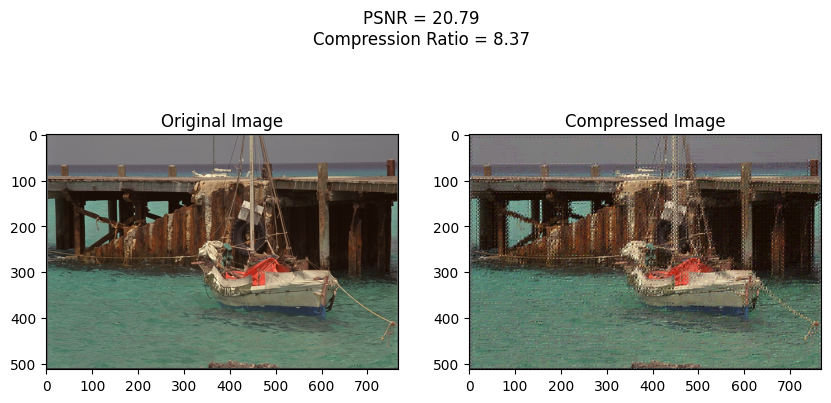

In [ ]:
if __name__ == "__main__":
    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients passed: "))
        color = input("Is the image color (y/n): ") == "y"
        output_path = input("Enter the output path for the compressed image: ")
        img, compressed_img, psnr, compression_ratio, encoded_img, color = analyze_image(img_path, block_size, num_coefficients, color)
        plot_images(*analyze_image(img_path, block_size, num_coefficients, color))
        save_compressed_image(compressed_img, output_path)

    elif input("Analyze all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        color = input("Are the images color (y/n): ") == "y"
        plot_graph(img_dir_path, color)

Analyze a single image (y/n): y
Enter the path to the image: /content/5.tif
Enter the block size (even): 8
Enter the number of coefficients passed: 10
Is the image color (y/n): n


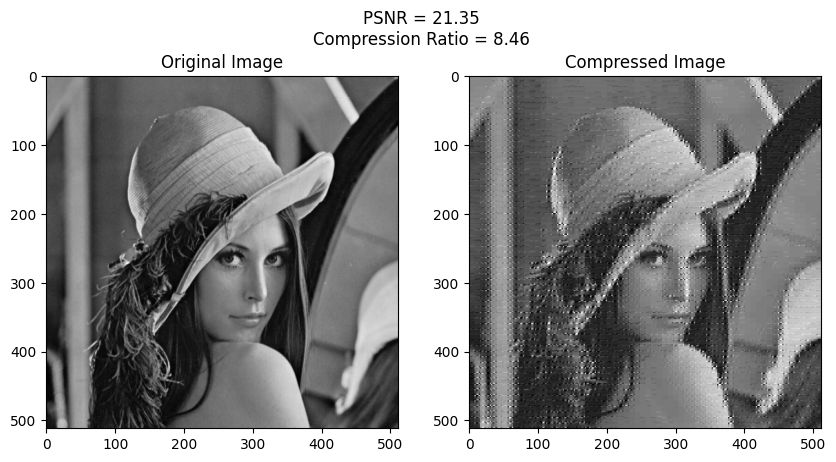

In [ ]:
if __name__ == "__main__":
    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients passed: "))
        color = input("Is the image color (y/n): ") == "y"
        plot_images(*analyze_image(img_path, block_size, num_coefficients, color))
    elif input("Analyze all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        color = input("Are the images color (y/n): ") == "y"
        plot_graph(img_dir_path, color)

## Image Compression with DCT

In [ ]:
# Import the required modules
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
quantization_matrix = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ],
    dtype=np.float32,
)

In [ ]:
def calculate_psnr(img1: np.ndarray[np.uint8], img2: np.ndarray[np.uint8]) -> float:
    """Calculate PSNR using formula: PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)"""
    mse = np.mean((img1 - img2) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    return psnr


def number_of_elements(blocks: list[np.ndarray[np.int32]]) -> int:
    """Calculates the total number of elements in the grayscale JPEG encoded array"""
    total_elements = 0
    for block in blocks:
        # Trim the trailing zeros from the 1D array
        total_elements += np.trim_zeros(block, "b").size
    return total_elements

In [ ]:
def total_number_of_elements(
    blocks: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    color: bool,
) -> int:
    """
    Calculates the total number of elements for both color and grayscale JPEG encoded arrays
    This is a utility function that will be used to calculate the compression ratio
    """
    total_elements = 0
    if color:
        # Add the number of elements for each color channel
        total_elements = (
            number_of_elements(blocks[0])
            + number_of_elements(blocks[1])
            + number_of_elements(blocks[2])
        )
    else:
        total_elements = number_of_elements(blocks)
    return total_elements



In [ ]:
def zigzag_scan(block: np.ndarray[np.int32]) -> np.ndarray[np.int32]:
    """
    Scans a block in zigzag order and return a 1D array
    Each block is assumed to be a square matrix
    """
    block_size = block.shape[0]
    zigzag_arr = np.concatenate(
        [
            np.diagonal(block[::-1, :], i)[:: (2 * (i % 2) - 1)]
            for i in range(1 - block_size, block_size)
        ]
    )
    return zigzag_arr


In [ ]:
def zigzag_unscan(
    zigzag_arr: np.ndarray[np.int32], block_size: int
) -> np.ndarray[np.float32]:
    """Unscans a 1D array in zigzag order and return a 2D array"""
    # Create an empty 2D array to store the unscanned values
    block = np.zeros((block_size, block_size), dtype=np.float32)
    x, y = 0, 0
    for num in zigzag_arr:
        # Set the current value in the corresponding coordinate of the 2D array
        block[x, y] = num

        # Determine the direction to move based on the current position
        # if the sum of the coordinates is even
        if (x + y) % 2 == 0:
            # if at the last column, move down one row
            if y == block_size - 1:
                x += 1
            # if at the first row, move right one column
            elif x == 0:
                y += 1
            # otherwise move up one row and right one column
            else:
                x -= 1
                y += 1
        # if the sum of the coordinates is odd
        else:
            # if at the last row, move right one column
            if x == block_size - 1:
                y += 1
            # if at the first column, move down one row
            elif y == 0:
                x += 1
            # otherwise move down one row and left one column
            else:
                x += 1
                y -= 1

    # return the 2D array with the unscanned values
    return block


In [ ]:
def grayscale_jpeg_encoder(
    img: np.ndarray[np.uint8], block_size: int, num_coefficients: int
) -> list[np.ndarray[np.int32]]:
    """
    Encodes a grayscale image using JPEG compression
    Returns a list of 1D arrays containing the first `num_coefficients`
    coefficients after performing zigzag scanning on each quantized block
    This is the JPEG encoded array
    """
    # Pad the image to make it divisible by the block size
    height, width = img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size
    padded_img = np.zeros((padded_height, padded_width), dtype=np.uint8)
    padded_img[:height, :width] = img

    # Subtract 128 from the image
    padded_img = padded_img.astype(np.float32) - 128

    # Split the image into blocks of the given size
    blocks = [
        padded_img[i : i + block_size, j : j + block_size]
        for i in range(0, padded_height, block_size)
        for j in range(0, padded_width, block_size)
    ]

    # Apply the Discrete Cosine Transform (DCT) to each block
    dct_blocks = [cv.dct(block) for block in blocks]

    # Resize the quantization matrix to match the block size
    resized_quantization_matrix = cv.resize(
        quantization_matrix, (block_size, block_size), cv.INTER_CUBIC
    )

    # Quantize each DCT coefficient by dividing with the resized quantization matrix
    quantized_blocks = [
        np.round(block / resized_quantization_matrix).astype(np.int32)
        for block in dct_blocks
    ]

    # Perform zigzag scanning on each quantized block
    zigzag_scanned_blocks = [zigzag_scan(block) for block in quantized_blocks]

    # Retain only the first `num_coefficients` coefficients in each block
    first_num_coefficients = [
        block[:num_coefficients] for block in zigzag_scanned_blocks
    ]

    return first_num_coefficients

In [ ]:
def grayscale_jpeg_decoder(
    blocks: list[np.ndarray[np.int32]], img: np.ndarray[np.uint8], block_size: int
) -> np.ndarray[np.uint8]:
    """
    Decodes a grayscale image using JPEG compression from the JPEG encoded array
    Returns a 2D array containing the compressed image
    """
    # Calculated the padded height and width of the image
    height, width = img.shape
    padded_height = height + (block_size - height % block_size) % block_size
    padded_width = width + (block_size - width % block_size) % block_size

    # Resize the quantization matrix to match the block size
    resized_quantization_matrix = cv.resize(
        quantization_matrix, (block_size, block_size), cv.INTER_CUBIC
    )

    # Unscan the zigzag scanned blocks to get the quantized blocks
    zigzag_unscanned_blocks = [zigzag_unscan(block, block_size) for block in blocks]

    # Dequantize the quantized blocks using the resized quantization matrix
    dequantized_blocks = [
        block * resized_quantization_matrix for block in zigzag_unscanned_blocks
    ]

    # Apply the Inverse Discrete Cosine Transform (IDCT) to each dequantized block
    idct_blocks = [cv.idct(block) for block in dequantized_blocks]

    # Reconstruct the compressed image from the IDCT blocks
    compressed_img = np.zeros((padded_height, padded_width), dtype=np.float32)
    block_index = 0
    for i in range(0, padded_height, block_size):
        for j in range(0, padded_width, block_size):
            compressed_img[i : i + block_size, j : j + block_size] = idct_blocks[
                block_index
            ]
            block_index += 1

    compressed_img += 128

    # Crop the image back to its original size
    compressed_img = np.clip(compressed_img, 0, 255)
    return compressed_img[:height, :width].astype(np.uint8)

In [ ]:
def color_jpeg_encoder(
    img: np.ndarray[np.uint8], block_size: int, num_coefficients: int
) -> tuple[
    list[np.ndarray[np.int32]], list[np.ndarray[np.int32]], list[np.ndarray[np.int32]]
]:
    """
    Encodes a color image using JPEG compression
    Returns a tuple of 3 lists, each containing
    1D arrays containing the first `num_coefficients`
    coefficients after performing zigzag scanning on each quantized block
    This is the JPEG encoded array
    The three lists correspond to the blue, green, and red channels respectively
    """
    # Split the image into blue, green and red channels
    blue_channel, green_channel, red_channel = cv.split(img)

    # Encode each channel using grayscale_jpeg_encoder
    return (
        grayscale_jpeg_encoder(blue_channel, block_size, num_coefficients),
        grayscale_jpeg_encoder(green_channel, block_size, num_coefficients),
        grayscale_jpeg_encoder(red_channel, block_size, num_coefficients),
    )


In [ ]:
def color_jpeg_decoder(
    blocks: tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    img: np.ndarray[np.uint8],
    block_size: int,
) -> np.ndarray[np.uint8]:
    """
    Decodes a JPEG encoded color image
    Returns a 3D array containing the compressed image
    """
    # Split the grayscale image into its color channels
    blue_channel, green_channel, red_channel = cv.split(img)

    # Decode each color channel using grayscale_jpeg_decoder
    blue_channel = grayscale_jpeg_decoder(blocks[0], blue_channel, block_size)
    green_channel = grayscale_jpeg_decoder(blocks[1], green_channel, block_size)
    red_channel = grayscale_jpeg_decoder(blocks[2], red_channel, block_size)

    # Merge the decoded color channels into a color image
    return cv.merge((blue_channel, green_channel, red_channel))


In [ ]:
def jpeg_encoder(
    img_path: str,
    block_size: int,
    num_coefficients: int,
    color: bool,
) -> (
    list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ]
):
    """
    Encodes an image using JPEG compression
    Returns the JPEG encoded array
    """
    if color:
        # Load color image and apply color JPEG encoder
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        return color_jpeg_encoder(img, block_size, num_coefficients)
    else:
        # Load grayscale image and apply grayscale JPEG encoder
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        return grayscale_jpeg_encoder(img, block_size, num_coefficients)



In [ ]:
def jpeg_decoder(
    blocks: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    img_path: str,
    block_size: int,
    color: bool,
) -> np.ndarray[np.uint8]:
    """
    Decodes an image using JPEG compression from its JPEG encoded array
    Returns a 2D or 3D array containing the compressed image
    """
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        return color_jpeg_decoder(blocks, img, block_size)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        return grayscale_jpeg_decoder(blocks, img, block_size)


In [ ]:
def analyze_image(
    img_path: str, block_size: int, num_coefficients: int, color: bool
) -> tuple[
    np.ndarray[np.uint8],
    np.ndarray[np.uint8],
    float,
    float,
    list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    bool,
]:
    """
    Analyzes the input image by performing JPEG compression,
    Returns the original and compressed images, and the PSNR and compression ratio
    This can be used to compare the quality of the compressed image
    """
    # Read the image
    img: np.ndarray[np.uint8] = None
    if color:
        img = cv.imread(img_path, cv.IMREAD_COLOR)
    else:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    # Encode the image using JPEG compression
    encoded_img = jpeg_encoder(img_path, block_size, num_coefficients, color)

    # Decode the image using JPEG compression
    compressed_img = jpeg_decoder(encoded_img, img_path, block_size, color)

    # Calculate the PSNR between the original and compressed images
    psnr = cv.PSNR(img, compressed_img)

    # Calculate the compression ratio
    n2 = total_number_of_elements(encoded_img, color)
    if n2 == 0:
        # In this case, the compression ratio is very high
        # But, we set it to 0 to avoid division by 0 so that our analysis becomes easier
        compression_ratio = 0
    else:
        compression_ratio = img.size / total_number_of_elements(encoded_img, color)

    # Return the original image, compressed image, PSNR, and compression ratio
    # Also return the encoded image and whether the image is color or not
    # The encoded image is returned so that it can be written in a text file
    return (img, compressed_img, psnr, compression_ratio, encoded_img, color)



In [ ]:
def plot_images(
    img: np.ndarray[np.uint8],
    compressed_img: np.ndarray[np.uint8],
    psnr: float,
    compression_ratio: float,
    encoded_img: list[np.ndarray[np.int32]]
    | tuple[
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
        list[np.ndarray[np.int32]],
    ],
    color: bool,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(
        "PSNR = {:.2f}\nCompression Ratio = {:.2f}".format(psnr, compression_ratio)
    )

    with open("encoded_image.txt", "w") as f:
        if color:
            axs[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            axs[1].imshow(cv.cvtColor(compressed_img, cv.COLOR_BGR2RGB))
            for row in zip(*encoded_img):
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

        else:
            axs[0].imshow(img, cmap="gray")
            axs[1].imshow(compressed_img, cmap="gray")
            for row in encoded_img:
                for element in row:
                    f.write(str(element) + " ")
                f.write("\n")

    axs[0].set_title("Original Image")

    axs[1].set_title("Compressed Image")
    plt.show()


In [ ]:
def plot_graph(
    img_dir_path: str,
    color: bool,
):
    psnr_list = []
    compression_ratio_list = []
    for num_coefficients in [1, 3, 6, 10, 15, 28]:
        psnr_values = []
        compression_ratio_values = []
        for img_file in os.listdir(img_dir_path):
            img_path = os.path.join(img_dir_path, img_file)
            _, _, psnr, compression_ratio, _, _ = analyze_image(
                img_path, 8, num_coefficients, color
            )
            psnr_values.append(psnr)
            compression_ratio_values.append(compression_ratio)
        psnr_list.append(np.mean(psnr_values))
        compression_ratio_list.append(np.mean(compression_ratio_values))

    plt.plot(compression_ratio_list, psnr_list, "o")
    plt.xlabel("Compression Ratio")
    plt.ylabel("PSNR")
    plt.title("PSNR vs Compression Ratio")
    plt.show()

In [ ]:
def save_compressed_image(compressed_img_DCT, output_path):
    """Save the compressed image to a specified output path."""
    output_path = output_path + ".jpg"
    cv.imwrite(output_path, compressed_img_DCT)

Analyze a single image (y/n): y
Enter the path to the image: /content/11.png
Enter the block size (even): 8
Enter the number of coefficients passed: 10
Is the image color (y/n): y
Enter the output path for the compressed image: C:\Users\Aindrila\OneDrive\Desktop\scientific working


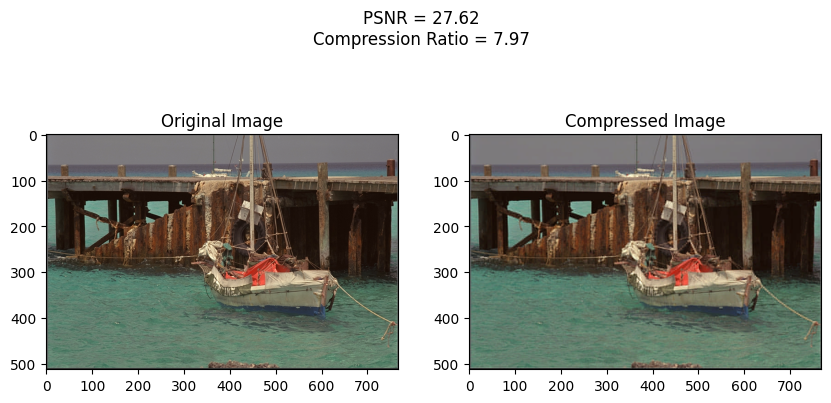

In [ ]:
if __name__ == "__main__":
    """
    Replace the image path with the path to your image
    plot_images function plots the original and compressed images
    Also, it wries the encoded images to a text file encoded_image.txt
    """
    # plot_images(*analyze_image(img_path="path/to/your/image", block_size=8, num_coefficients=10, color=True))

    """
    Replaces the images folder with the path to your images folder
    plot_graph function plots the PSNR vs Compression Ratio graph
    for all the images in the images folder for different values of num_coefficients
    """
    # plot_graph(img_dir_path="path/to/your/image/folder", color=False)

    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients passed: "))
        color = input("Is the image color (y/n): ") == "y"
        output_path = input("Enter the output path for the compressed image: ")
        plot_images(*analyze_image(img_path, block_size, num_coefficients, color))
        img, compressed_img_DCT, psnr, compression_ratio, encoded_img, color = analyze_image(img_path, block_size, num_coefficients, color)
        save_compressed_image(compressed_img_DCT, output_path)
    elif input("Analyzes all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        color = input("Are the images color (y/n): ") == "y"
        plot_graph(img_dir_path, color)

Analyze a single image (y/n): y
Enter the path to the image: /content/5.tif
Enter the block size (even): 8
Enter the number of coefficients passed: 10
Is the image color (y/n): n


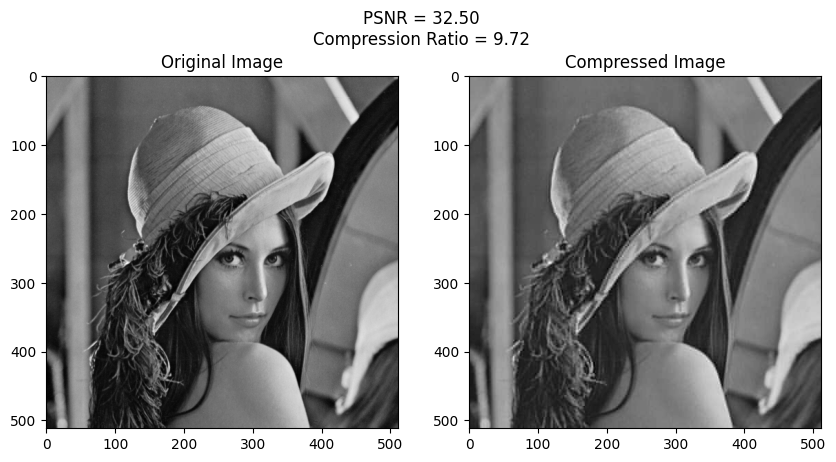

In [ ]:
if __name__ == "__main__":
    """
    Replace the image path with the path to your image
    plot_images function plots the original and compressed images
    Also, it wries the encoded images to a text file encoded_image.txt
    """
    # plot_images(*analyze_image(img_path="path/to/your/image", block_size=8, num_coefficients=10, color=True))

    """
    Replaces the images folder with the path to your images folder
    plot_graph function plots the PSNR vs Compression Ratio graph
    for all the images in the images folder for different values of num_coefficients
    """
    # plot_graph(img_dir_path="path/to/your/image/folder", color=False)

    if input("Analyze a single image (y/n): ") == "y":
        img_path = input("Enter the path to the image: ")
        block_size = int(input("Enter the block size (even): "))
        num_coefficients = int(input("Enter the number of coefficients passed: "))
        color = input("Is the image color (y/n): ") == "y"
        plot_images(*analyze_image(img_path, block_size, num_coefficients, color))
    elif input("Analyzes all images in a folder (y/n): ") == "y":
        img_dir_path = input("Enter the path to the images folder: ")
        color = input("Are the images color (y/n): ") == "y"
        plot_graph(img_dir_path, color)

# Calculating Perceptual Similarity Metric

In [ ]:
!git clone https://github.com/richzhang/PerceptualSimilarity.git


Cloning into 'PerceptualSimilarity'...
remote: Enumerating objects: 800, done.
remote: Counting objects: 100% (797/797), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 800 (delta 470), reused 783 (delta 461), pack-reused 3
Receiving objects: 100% (800/800), 8.76 MiB | 21.66 MiB/s, done.
Resolving deltas: 100% (470/470), done.


In [ ]:
%cd PerceptualSimilarity
!pip install -r requirements.txt


/content/PerceptualSimilarity
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_c

In [ ]:
import sys
sys.path.append('/content/PerceptualSimilarity')


In [ ]:
import os
from PIL import Image
from util import util
from lpips import lpips as dm

In [ ]:
image_path = '/content/11.png'  # Update this path
mdct_compressed_path = '/content/compressed_mdct.jpg'  # Update this path
dct_compressed_path = '/content/compressed_dct.jpg'  # Update this path

# Load images
original_image = Image.open(image_path).convert('RGB')
mdct_compressed_image = Image.open(mdct_compressed_path).convert('RGB')
dct_compressed_image = Image.open(dct_compressed_path).convert('RGB')

# Initialize model
model = dm.LPIPS(net='alex')  # Corrected model initialization

# Convert images to tensors
original_tensor = util.im2tensor(np.array(original_image)) # Convert to NumPy array before passing to im2tensor
mdct_compressed_tensor = util.im2tensor(np.array(mdct_compressed_image))
dct_compressed_tensor = util.im2tensor(np.array(dct_compressed_image))
# Compute perceptual similarity
mdct_similarity = model.forward(original_tensor, mdct_compressed_tensor)
dct_similarity = model.forward(original_tensor, dct_compressed_tensor)

print(f"Perceptual Similarity for MDCT: {mdct_similarity.item()}")
print(f"Perceptual Similarity for DCT: {dct_similarity.item()}")

def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

# Calculate file sizes
original_size = get_file_size(image_path)
mdct_compressed_size = get_file_size(mdct_compressed_path)
dct_compressed_size = get_file_size(dct_compressed_path)

# Calculate compression ratios
mdct_compression_ratio = original_size / mdct_compressed_size
dct_compression_ratio = original_size / dct_compressed_size

# Calculate bits per pixel
width, height = get_image_dimensions(image_path)
total_pixels = width * height
mdct_bpp = (mdct_compressed_size * 8) / total_pixels
dct_bpp = (dct_compressed_size * 8) / total_pixels

print(f"Compression Ratio for MDCT: {mdct_compression_ratio}")
print(f"Compression Ratio for DCT: {dct_compression_ratio}")
print(f"Bits Per Pixel for MDCT Version: {mdct_bpp}")
print(f"Bits Per Pixel for DCT: {dct_bpp}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /content/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
Perceptual Similarity for MDCT: 0.3523385524749756
Perceptual Similarity for DCT: 0.2550155818462372
Compression Ratio for MDCT: 3.5065243781937268
Compression Ratio for DCT: 8.115401704040563
Bits Per Pixel for MDCT Version: 3.60321044921875
Bits Per Pixel for DCT: 1.556884765625


## Interpretation of Results
*Perceptual Similarity*:

**MDCT**: 0.3523
**DCT**: 0.2550
Lower values indicate better perceptual similarity. Therefore, DCT has better perceptual similarity compared to MDCT.

*Compression Ratio*:

**MDCT**: 3.5065
**DCT**: 8.1154
Higher values indicate better compression. Thus, DCT achieves a better compression ratio than MDCT.

*Bits Per Pixel (BPP):*

**MDCT**: 3.6032
**DCT**: 1.5569
Lower BPP values indicate more efficient compression. DCT has a lower BPP, meaning it compresses the image more efficiently than MDCT.

Based on these metrics:
DCT outperforms MDCT in terms of both perceptual similarity and compression efficiency.